In [14]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as miss

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib

## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## Matplotlib style
fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.1}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'

In [8]:
# Run the following command on your local computer to check the version of sklearn
import sklearn

!python --version
print(f"sklearn version: {sklearn.__version__}")

sklearn version: 1.1.3


& was unexpected at this time.


In [2]:
## Load in data
df = pd.read_csv('Data/sales_predictions.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [3]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [22]:
df.duplicated().sum()

0

In [25]:
df.replace(['LF','low fat'],['Low Fat','Low Fat'], inplace = True)
df.replace(['reg'],['Regular'], inplace = True)
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [26]:
y = df['Item_Outlet_Sales']
X = df.drop(columns=['Item_Outlet_Sales', 'Outlet_Identifier', 'Outlet_Location_Type', 'Item_Identifier'])

## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)
X_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Type
8269,7.2200,Regular,0.0641,Baking Goods,61.2510,1998,NaN,Grocery Store
7604,6.1350,Low Fat,0.0793,Soft Drinks,111.2860,2009,Medium,Supermarket Type2
2762,12.1500,Low Fat,0.0286,Household,151.0708,2004,Small,Supermarket Type1
6464,5.9450,Low Fat,0.0930,Household,127.8652,2004,Small,Supermarket Type1
4707,18.2000,Regular,0.0663,Fruits and Vegetables,247.2092,2004,Small,Supermarket Type1


In [27]:
## make pipelines for categorical vs numeric data
cat_sel = make_column_selector(dtype_include='object')
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False))

num_sel = make_column_selector(dtype_include='number')
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))


## make the preprocessing column transformer with verbose_feature_names_out=False
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),
                                      verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000026017544250>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000026017544FA0>)],
                  verbose_feature_names_out=False)

In [29]:
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()

X_train_df = pd.DataFrame(preprocessor.transform(X_train), 
                          columns = feature_names, index = X_train.index)

X_test_df = pd.DataFrame(preprocessor.transform(X_test), 
                          columns = feature_names, index = X_test.index)
X_test_df.head(3)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,...,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Size_High,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
8077,15.2500,0.0615,132.2968,"2,007.0000",1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
2391,17.8500,0.0445,127.1020,"1,997.0000",1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000
163,7.2700,0.0711,114.2518,"1,997.0000",1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000


# LinearRegression

In [11]:
def evaluate_regression(model, X_train,y_train, X_test, y_test,for_slides=True): 
    """Evaluates a scikit learn regression model using r-squared and RMSE
    FOR SLIDES VERS DOES MULTIPLE PRINT STATEMENTS FOR VERTICAL DISPLAY OF INFO"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    

    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
    
    if for_slides:
        df_version =[['Split','R^2','MAE','RMSE']]
        df_version.append(['Train',r2_train, mae_train, rmse_train])
        df_version.append(['Test',r2_test, mae_test, rmse_test])
        df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
        df_results = df_results.round(2)
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))
        
    else: 
        print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
        print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")

In [31]:
from sklearn.linear_model import LinearRegression
lin_reg= LinearRegression()
lin_reg.fit(X_train_df,y_train)
evaluate_regression(lin_reg, X_train_df, y_train, 
                    X_test_df, y_test)

Split,R^2,MAE,RMSE
Train,0.56,826.99,"1,115.40"
Test,0.56,859.62,"1,164.52"


In [32]:
def get_coefficients(lin_reg):
    coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
    coeffs.loc['intercept'] = lin_reg.intercept_
    return coeffs

In [33]:
coeffs = get_coefficients(lin_reg)
coeffs

Item_Weight                             1.0880
Item_Visibility                      -264.1869
Item_MRP                               15.5939
Outlet_Establishment_Year              19.0395
Item_Fat_Content_Low Fat              -15.3509
Item_Fat_Content_Regular               15.3509
Item_Type_Baking Goods                  8.8458
Item_Type_Breads                       -4.3813
Item_Type_Breakfast                    70.4669
Item_Type_Canned                       22.6886
Item_Type_Dairy                       -47.8971
Item_Type_Frozen Foods                 -5.1619
Item_Type_Fruits and Vegetables        15.7784
Item_Type_Hard Drinks                  45.5064
Item_Type_Health and Hygiene          -41.1499
Item_Type_Household                   -69.7977
Item_Type_Meat                        -16.0712
Item_Type_Others                       19.9744
Item_Type_Seafood                      99.7184
Item_Type_Snack Foods                 -11.1030
Item_Type_Soft Drinks                -117.3100
Item_Type_Sta

In [34]:
## formatting numbers to not use , thousands sep, and 4 digits floats
pd.set_option('display.float_format',lambda x: f"{x:,.4f}")
pd.set_option('display.max_rows', None)

In [35]:
coeffs.sort_values()

intercept                         -38,066.3473
Outlet_Type_Grocery Store          -1,553.6001
Outlet_Type_Supermarket Type2        -378.4236
Item_Visibility                      -264.1869
Outlet_Size_MISSING                  -188.9594
Item_Type_Soft Drinks                -117.3100
Item_Type_Household                   -69.7977
Item_Type_Dairy                       -47.8971
Item_Type_Health and Hygiene          -41.1499
Outlet_Size_Small                     -19.6571
Item_Type_Meat                        -16.0712
Item_Fat_Content_Low Fat              -15.3509
Item_Type_Snack Foods                 -11.1030
Item_Type_Frozen Foods                 -5.1619
Item_Type_Breads                       -4.3813
Item_Weight                             1.0880
Outlet_Size_Medium                      4.7651
Item_Type_Baking Goods                  8.8458
Item_Fat_Content_Regular               15.3509
Item_MRP                               15.5939
Item_Type_Fruits and Vegetables        15.7784
Outlet_Establ

In [37]:
## Get a list of all of the ohe columsn
Item_Type_feats = [c for c in X_train_df.columns if c.startswith('Item_Type')]
len(Item_Type_feats)

16

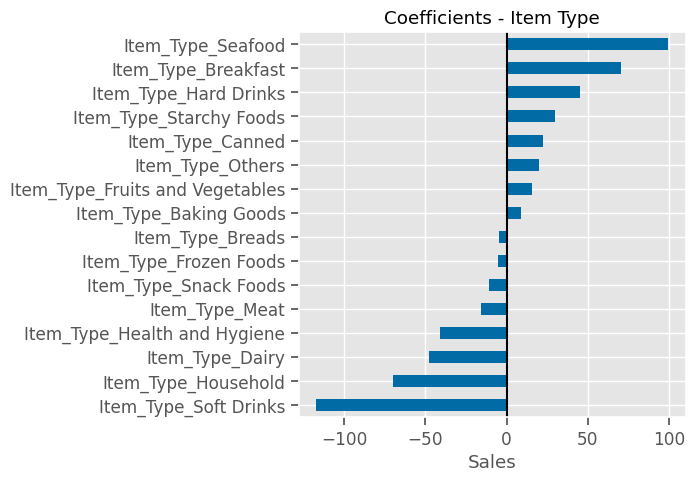

In [47]:
## Plot country ceoffs
ax = coeffs[Item_Type_feats].sort_values().plot(kind='barh', figsize=(5,5))
ax.axvline(0, color='k')
ax.set(xlabel='Sales', title="Coefficients - Item Type");

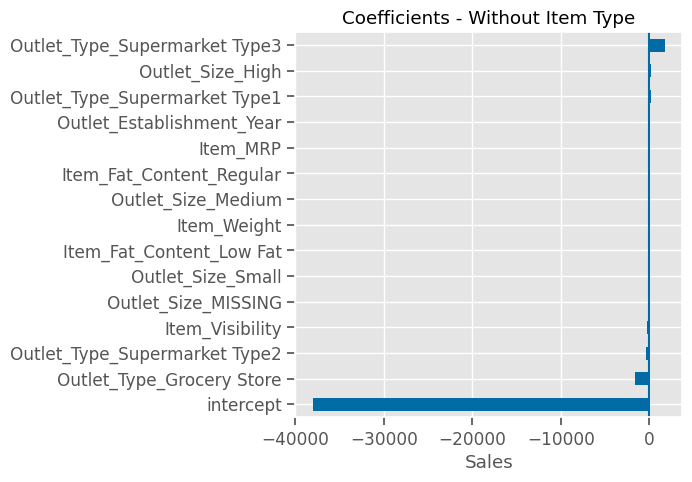

In [48]:
## Plot everything but item identifier
ax = coeffs.drop(Item_Type_feats).sort_values().plot(kind='barh', figsize=(5,5))
ax.axvline(0)
ax.set(xlabel='Sales', title="Coefficients - Without Item Type");

plt.savefig('Data/coeffs.png')

## Top 3 Most impactful features

From above coefficients graph, we know that these are the Top 3 Most impactful Features:

- Outlet Type Supermarket Type 3
 - Have the highest coefficients among features which that Type 3 Supermarket have more sales than others.
 
- Outlet Size High
 - Sales tend to be better in bigger size outlet.
 
- Outlet Type Supermarket Type 1
 - Type 1 Supermarket have better sales than Type 2 but not Type 3 which is has the highest coefficients.
 

# Tree-Based Model

In [49]:
reg = RandomForestRegressor(random_state=SEED)
reg.fit(X_train_df,y_train)
evaluate_regression(reg, X_train_df, y_train, X_test_df, y_test)

Split,R^2,MAE,RMSE
Train,0.94,295.11,426.87
Test,0.56,820.63,"1,169.09"


In [50]:
## Saving the coefficients
importances = pd.Series(reg.feature_importances_, index= reg.feature_names_in_)
importances

Item_Weight                       0.0534
Item_Visibility                   0.1007
Item_MRP                          0.4480
Outlet_Establishment_Year         0.0398
Item_Fat_Content_Low Fat          0.0050
Item_Fat_Content_Regular          0.0048
Item_Type_Baking Goods            0.0045
Item_Type_Breads                  0.0030
Item_Type_Breakfast               0.0025
Item_Type_Canned                  0.0042
Item_Type_Dairy                   0.0056
Item_Type_Frozen Foods            0.0057
Item_Type_Fruits and Vegetables   0.0082
Item_Type_Hard Drinks             0.0029
Item_Type_Health and Hygiene      0.0043
Item_Type_Household               0.0062
Item_Type_Meat                    0.0037
Item_Type_Others                  0.0016
Item_Type_Seafood                 0.0015
Item_Type_Snack Foods             0.0079
Item_Type_Soft Drinks             0.0042
Item_Type_Starchy Foods           0.0028
Outlet_Size_High                  0.0032
Outlet_Size_MISSING               0.0060
Outlet_Size_Medi

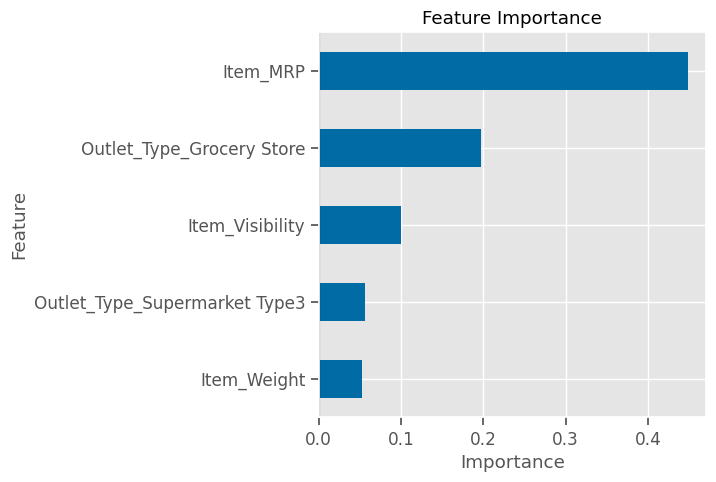

In [54]:
ax = importances.sort_values().tail(5).plot(kind='barh',figsize=(5,5))
ax.axvline(0, color='k')
ax.set(title='Feature Importance',ylabel="Feature",
      xlabel='Importance');

plt.savefig('Data/importances.png', bbox_inches="tight")

## Top 5 most important features:

- Item MRP
    - Item Market Retail Price are the most important factor for Sales.
- Outlet Type Grocery Store
 - Grocery Store has better sales than other outlet types.
- Item Visibility
 - its important to have good visibility for selling items, better visibility more likely to engage with consumers and maximise sales.
- Outlet Type Supermarket Type3
  - People are likely to go to type 3, it could be the interior design/ style of the supermarket or size tend to have more people like to go there.
- Item Weight 
 - Item Weights are matter so people could probably tend to do online delivery for heavier items.


# Serialize Our Best Model with Joblib

In [56]:
reg = RandomForestRegressor(random_state=SEED)
reg.fit(X_train_df,y_train)
evaluate_regression(reg, X_train_df, y_train, X_test_df, y_test)

Split,R^2,MAE,RMSE
Train,0.94,295.11,426.87
Test,0.56,820.63,"1,169.09"


In [59]:
import joblib, os

## creating a dictionary of all of the variables to save for later
export = {'X_train':X_train_df,
         'y_train':y_train,
         'X_test':X_test_df,
         'y_test':y_test,
          'preprocessor':preprocessor,
          'RandomForestRegressor':reg}
joblib.dump(export, 'random_forest.joblib')

['random_forest.joblib']